In [1]:
# Copyright (c) 2024 Microsoft Corporation.
# Licensed under the MIT License

### use_built_in_workflows
#### init csv file

In [2]:
# our fake dataset
import asyncio
from pathlib import Path
import pandas as pd
import os
from graphrag.index.config import PipelineCSVInputConfig
from graphrag.index.input import load_input
init_dataset = pd.DataFrame([{"author": "aufsnn", 
                         "message": "Apple Inc. is an American multinational technology company headquartered in Cupertino, California. Tim Cook is the CEO of Apple.",
                         "date(yyyyMMddHHmmss)": "20240709182511"
                        }])

sample_data_dir = os.path.join(
    Path().cwd(), "input/"
)
if not os.path.exists(sample_data_dir):
    os.makedirs(sample_data_dir)
init_dataset.to_csv(f'{sample_data_dir}/dataset.csv', index=False)
sample_data_dir

'/media/gpt4-pdf-chatbot-langchain/graphrag/examples_notebooks/8_use_built_in_workflows/input/'

In [3]:

shared_dataset = await load_input(
        PipelineCSVInputConfig(
            file_pattern=".*\\.csv$",
            base_dir=sample_data_dir,
            source_column="author",
            text_column="message",
            timestamp_column="date(yyyyMMddHHmmss)",
            timestamp_format="%Y%m%d%H%M%S",
            title_column="message",
        ),
    )
# We're cheap, and this is an example, lets just do 10
dataset = shared_dataset.head(10)
dataset

,author,message,date(yyyyMMddHHmmss),id,source,text,title,timestamp,year,month,day,hour,minute,second
0,aufsnn,Apple Inc. is an American multinational techno...,20240709182511,a9c886cbbc2905f65301a9215514ed0b,aufsnn,Apple Inc. is an American multinational techno...,Apple Inc. is an American multinational techno...,2024-07-09 18:25:11,2024,7,9,18,25,11


In [4]:

# Copyright (c) 2024 Microsoft Corporation.
# Licensed under the MIT License
from graphrag.index.workflows import WorkflowDefinitions
from graphrag.index import PipelineWorkflowStep, PipelineWorkflowConfig

def build_entity_extraction_steps(
        config: PipelineWorkflowConfig,
) -> list[PipelineWorkflowStep]:
    entity_extraction_config = config.get("entity_extract", {})

    return [
        {
            "verb": "entity_extract",
            "args": {
                **entity_extraction_config,

                "column": "message",
                "id_column": "author",
                "async_mode": "asyncio",
                "to": "entities",
                "graph_to": "entity_graph",
            },
        },

    ]


def build_entity_graph_steps(
        config: PipelineWorkflowConfig,
) -> list[PipelineWorkflowStep]:
    clustering_config = config.get(
        "cluster_graph",
        {"strategy": {"type": "leiden"}},
    )
    embed_graph_config = config.get(
        "embed_graph",
        {
            "strategy": {
                "type": "node2vec",
                "num_walks": config.get("embed_num_walks", 10),
                "walk_length": config.get("embed_walk_length", 40),
                "window_size": config.get("embed_window_size", 2),
                "iterations": config.get("embed_iterations", 3),
                "random_seed": config.get("embed_random_seed", 86),
            }
        },
    )

    layout_graph_config = config.get(
        "layout_graph",
        {
            "strategy": {
                "type": "umap",
            },
        },
    )

    return [
        {
            "id": "custom_graph_nodes",
            "verb": "cluster_graph",
            "args": {
                **clustering_config,
                "column": "entity_graph",
                "to": "clustered_graph",
                "level_to": "level",
            },
            "input": ({"source": "workflow:entity_extraction"}),
        },
        {
            "id": "custom_embed_nodes",
            "verb": "embed_graph",
            "args": {

                "column": "clustered_graph",
                "to": "embeddings",
                **embed_graph_config,
            },

            "input": {"source": "custom_graph_nodes"},
        },
        {
            "id": "custom_laid_out_entity_graph",
            "verb": "layout_graph",
            "args": {
                "embeddings_column": "embeddings",
                "graph_column": "clustered_graph",
                "to": "node_positions",
                "graph_to": "positioned_graph",
                **layout_graph_config,
            },

            "input": {"source": "custom_embed_nodes", "others": ["custom_graph_nodes"]},
        },
    ]


custom_workflows: WorkflowDefinitions = {
    "entity_extraction": build_entity_extraction_steps,
    "entity_graph": build_entity_graph_steps
}



#### create pipeline workflows file

In [5]:
import pandas as pd

from pathlib import Path

PIPELINE_YAML = """
workflows:
  - name: "entity_extraction"
    config:
      entity_extract:
          strategy: 
              type: "nltk"

  - name: "entity_graph"
    config:
      cluster_graph: 
        strategy: 
          type: "leiden"
      embed_graph: 
          strategy: 
              type: "node2vec"
              num_walks: 10
              walk_length: 40
              window_size: 2
              iterations: 3
              random_seed: 597832
      layout_graph: 
          strategy: 
              type: "umap"
 
"""
pipeline_file =  Path().cwd() / "pipeline.yaml"
with pipeline_file.open("w") as file:
    file.write(PIPELINE_YAML)
    

In [6]:
# Load your config without the input section
config_path = str(pipeline_file)
config_path

'/media/gpt4-pdf-chatbot-langchain/graphrag/examples_notebooks/8_use_built_in_workflows/pipeline.yaml'

#### start pipeline entity_extraction\entity_graph workflow

In [7]:

from graphrag.index import run_pipeline_with_config
# Grab the last result from the pipeline, should be our entity extraction
tables = []
async for table in run_pipeline_with_config(
    config_or_path=config_path, dataset=dataset,additional_workflows=custom_workflows
):
    tables.append(table)
pipeline_result = tables[-1]

if pipeline_result.result is not None:
    # The output of this should match the run_python() example
    first_result = pipeline_result.result.head(1)
    print(f"level: {first_result['level'][0]}")
    print(f"embeddings: {first_result['embeddings'][0]}")
    print(f"entity_graph_positions: {first_result['node_positions'][0]}")
else:
    print("No results!")

[nltk_data] Downloading package punkt to /home/dmeck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dmeck/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/dmeck/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/dmeck/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dmeck/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/dmeck/.cache/pypoetry/virtualenvs/graphrag-C9AMInUh-py3.10/lib/python3.10/site-packages/graspologic/utils/utils.py:1142: UserWarning: Graph has at least one unweighted edge using weight_attribute "weight". Defaulting unweighted edges to "1.0"
  warnings.warn(
/home/dmeck/.cache/pypoetry/

Error emitting table ("Expected bytes, got a 'float' object", 'Conversion failed for column node_positions with type object') Traceback (most recent call last):
  File "/media/gpt4-pdf-chatbot-langchain/graphrag/graphrag/index/emit/parquet_table_emitter.py", line 40, in emit
    await self._storage.set(filename, data.to_parquet())
  File "/home/dmeck/.cache/pypoetry/virtualenvs/graphrag-C9AMInUh-py3.10/lib/python3.10/site-packages/pandas/util/_decorators.py", line 333, in wrapper
    return func(*args, **kwargs)
  File "/home/dmeck/.cache/pypoetry/virtualenvs/graphrag-C9AMInUh-py3.10/lib/python3.10/site-packages/pandas/core/frame.py", line 3113, in to_parquet
    return to_parquet(
  File "/home/dmeck/.cache/pypoetry/virtualenvs/graphrag-C9AMInUh-py3.10/lib/python3.10/site-packages/pandas/io/parquet.py", line 480, in to_parquet
    impl.write(
  File "/home/dmeck/.cache/pypoetry/virtualenvs/graphrag-C9AMInUh-py3.10/lib/python3.10/site-packages/pandas/io/parquet.py", line 190, in write


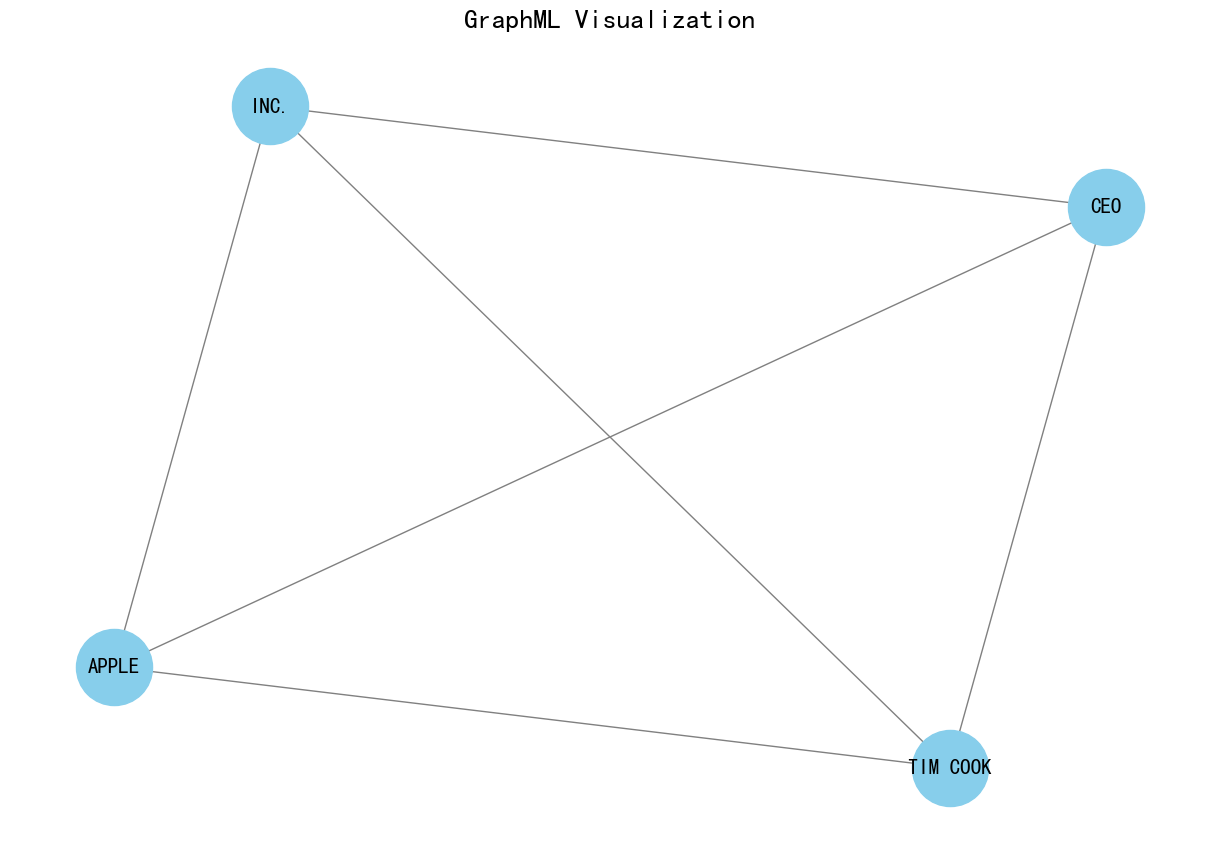

In [8]:
import matplotlib.pyplot as plt
from typing import Any, cast
import os
from pathlib import Path
import networkx as nx
import pandas as pd
from graphrag.index.utils import load_graph
from matplotlib import rcParams
import matplotlib.font_manager as fm

output_data_dir = os.path.join(
    Path().cwd(), "output/"
)

report_df = pd.read_parquet(f"{output_data_dir}/entity_extraction.parquet")

G = load_graph(cast(str | nx.Graph, report_df['entity_graph'][0]))

 # Set the font properties
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['SimHei']  # Use 'Noto Sans CJK' or another font that supports Chinese characters

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=3000, edge_color='gray', font_size=15, font_weight='bold')
plt.title('GraphML Visualization', size=20)
plt.show()
